In [1]:
from datetime import datetime as dt
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gammas = np.arange(0,1, 0.01) / 3
def get_eps(gamma):
    return np.log((0.5 + gamma)**2 / ((1/3.) - gamma)**2)
eps = [get_eps(g) for g in gammas]
delay = [2.5 - 2*g for g in gammas]

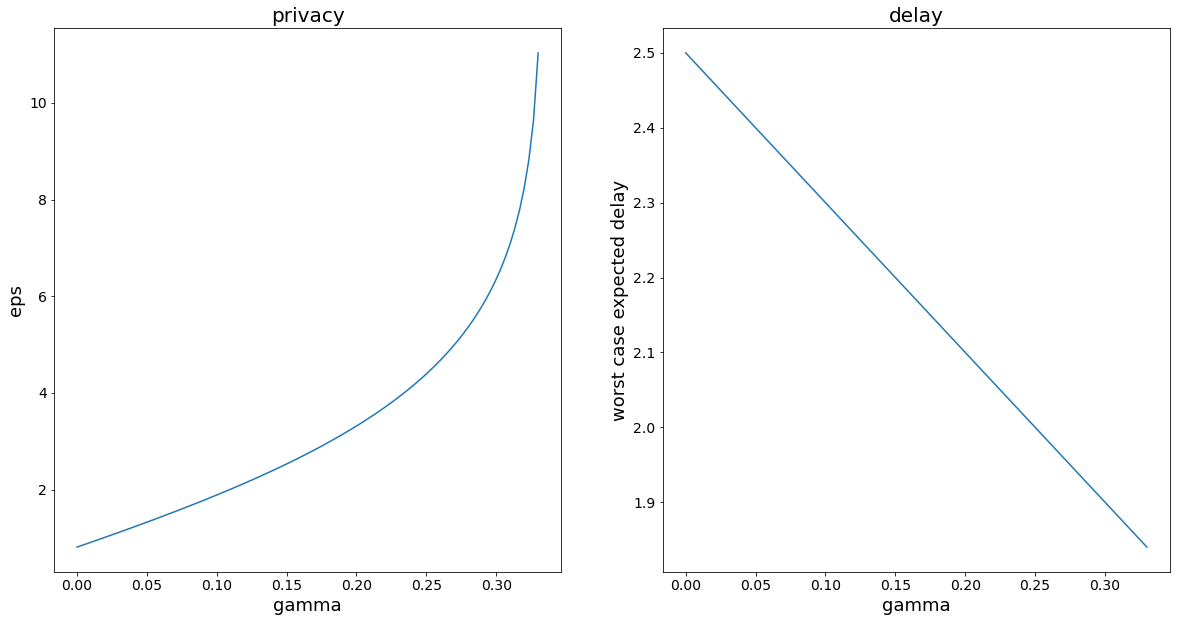

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
data = [eps, delay]
names = ['eps', 'worst case expected delay']
titles = ['privacy', 'delay']
for i, ax in enumerate(axes):
    ax.plot(gammas, data[i])
    ax.set_xlabel('gamma', fontsize=18)
    ax.set_ylabel(names[i], fontsize=18)
    ax.set_title(titles[i], fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=14) 
    plt.setp(ax.get_yticklabels(), fontsize=14) 

plt.show()

In [103]:
def expected_delay(g, eps):
    p = 1. - np.exp(-1*eps/(2*g))
    return g + ((1. - p) / p)

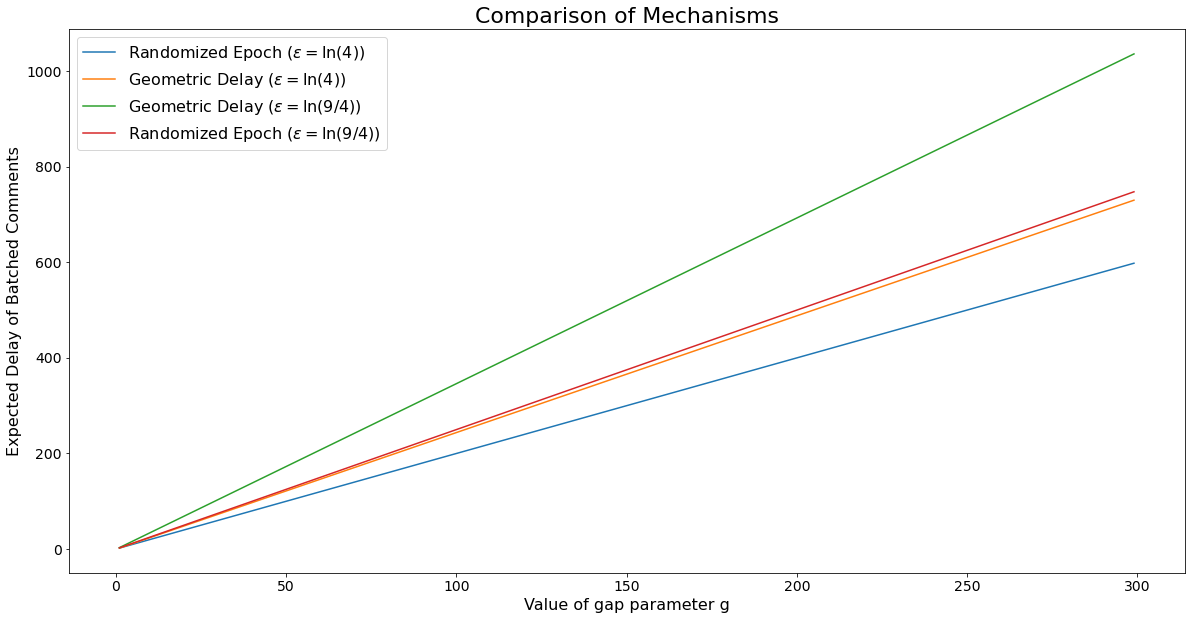

In [63]:
fig, axes = plt.subplots(figsize=(20,10))

gs = np.arange(1,300)

plt.plot(gs, [2*g for g in gs], label=r'Randomized Epoch ($\epsilon = \ln(4)$)')
plt.plot(gs, [expected_delay(g, np.log(4)) for g in gs], label='Geometric Delay ($\epsilon = \ln(4)$)')
plt.plot(gs, [expected_delay(g, np.log(9./4.)) for g in gs], label=r'Geometric Delay ($\epsilon = \ln(9/4)$)')
plt.plot(gs, [2.5*g for g in gs], label=r'Randomized Epoch ($\epsilon = \ln(9/4)$)')

plt.legend(fontsize=16)
plt.xlabel('Value of gap parameter g', fontsize=16)
plt.ylabel('Expected Delay of Batched Comments', fontsize=16)
plt.title('Comparison of Mechanisms', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

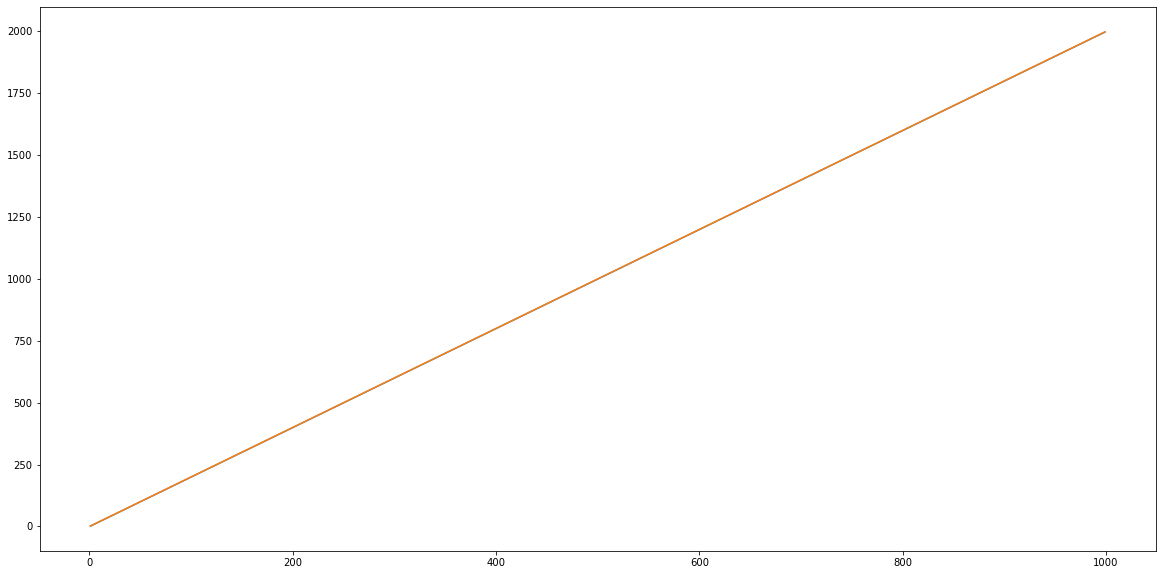

In [59]:
fig, axes = plt.subplots(figsize=(20,10))

plt.plot(np.arange(1,1000), [1/(np.exp(1/(2*g)) - 1) for g in np.arange(1,1000)])
plt.plot(np.arange(1,1000), [2*g for g in np.arange(1, 1000)])

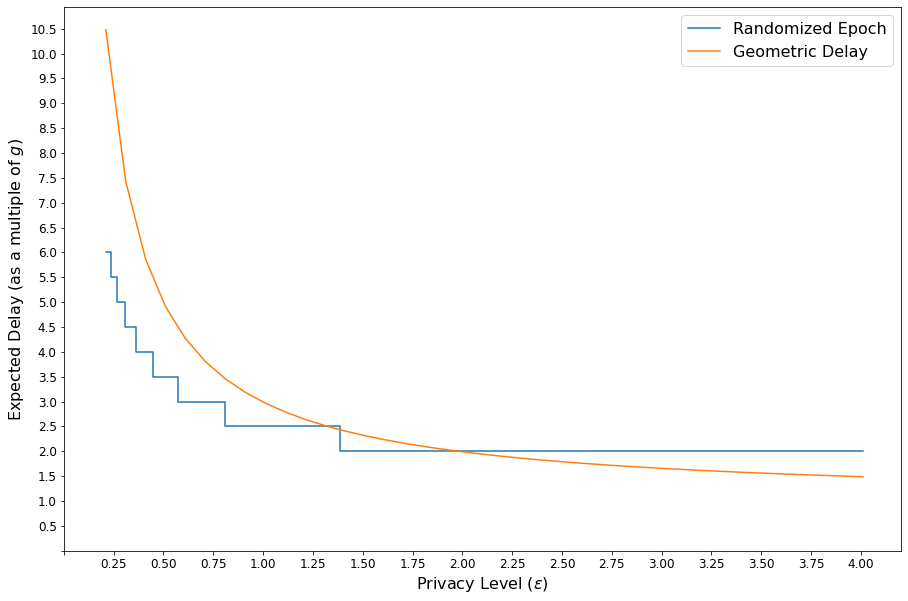

In [160]:
fig, axes = plt.subplots(figsize=(15,10))

g=60

K_max = 10
eps_max = 4.
eps_range = np.arange(2*np.log((K_max) / (K_max - 1)), eps_max + 0.1, 0.1)
expected_delays = [expected_delay(g, eps) / g for eps in eps_range]

K_range = [2*np.log((K+1) / K) for K in np.arange(1,K_max)]
K_range = [max(eps_range)] + K_range
delays = [1 + ((K+1)/2.) for K in np.arange(1, K_max)]
delays = [delays[0]] + delays

plt.step(K_range, delays, where='pre', label='Randomized Epoch') # 'ro-'
plt.plot(eps_range, expected_delays, label='Geometric Delay')

plt.legend(fontsize=16)

plt.yticks(ticks=np.arange(0., max(expected_delays)+0.1,0.5), fontsize=12)
axes.yaxis.get_major_ticks()[0].label1.set_visible(False)

plt.xticks(ticks=np.arange(0, eps_max+0.25,0.25), fontsize=12)
axes.xaxis.get_major_ticks()[0].label1.set_visible(False)

plt.ylabel(r'Expected Delay (as a multiple of $g$)', fontsize=16)

plt.xlabel(r'Privacy Level ($\epsilon$)', fontsize=16)


plt.show()